In [2]:
from model_and_circuit import *
from jax.lib import xla_bridge
jax.experimental.enable_x64()
print("JAX Backend:", xla_bridge.get_backend().platform)

JAX Backend: gpu


In [3]:
class MMD:
    def __init__(self,scales,space):
        gammas = 1/(2*(scales**2)).reshape(-1,1,1)
        sq_dists = jnp.abs(space[:,None] - space[None,:])**2
        self.K = jnp.sum(jnp.exp(-gammas * sq_dists), axis=0)/len(scales)
        self.scales = scales
        
    def k_expval(self,px,py):
        return px @ self.K @ py
    
    def __call__(self,px,py):
        # print(np.size(px),np.size(py))
        pxy = px-py
        return self.k_expval(pxy,pxy)
    
class QCBM:
    def __init__(self,circ,mmd,py):
        self.circ = circ
        self.mmd = mmd
        self.py = py
    
    def mmd_loss(self,params):
        px = self.circ(params)
        # print(np.size(px))
        return self.mmd(px,self.py), px
    

#Model Training
@jit
def update_step(params,opt_state):
    
    (loss_val,qcbm_probs), grads = jax.value_and_grad(qcbm.mmd_loss,has_aux=True)(params)

    updates,opt_state = opt.update(grads,opt_state)
    params = optax.apply_updates(params,updates)
    
    qcbm_probs = jnp.asarray(qcbm_probs, dtype=jnp.float64)
    
    kl_div = -jnp.sum(target_distribution * jnp.nan_to_num(jnp.log(qcbm_probs) - jnp.log(target_distribution)))
    
    return params, opt_state, loss_val, kl_div


In [ ]:
# #Load the Checkpoint

# with open('data/model_checkpoint_10010.pkl', "rb") as file:
#     checkpoint = pickle.load(file)

# start_epoch = checkpoint["epoch"] + 1
# params = checkpoint["model_params"]
# opt_state = checkpoint["optimizer_state"]
# loss_values = checkpoint["loss_history"]
# kl_values = checkpoint["kl_divergence"]

# print(f"Resuming training from epoch {start_epoch}...")

In [5]:
#Calling MMD class
bandwidth = jnp.array([0.25,60],dtype=jnp.float64)
space = jnp.arange(0,2**n_qubits,dtype=jnp.float64)
mmd = MMD(bandwidth,space=space)


#Calling QCBM class to run the previous built circuit with random weights
qcbm = QCBM(circuit,mmd=mmd,py=target_distribution)


#Initial parameters
weights = initial_params
lr = optax.exponential_decay(init_value=0.1,transition_steps=10,decay_rate=0.9,transition_begin=300,end_value=0.01,staircase=True)
opt = optax.adam(learning_rate=lr)
opt_state = opt.init(weights)


history = []
divs = []
parameters = []
# n_iterations = 400

kl_div = 1
i = 0
while kl_div > 10^-3:
# while i < 1000:
    i+=1
    current_lr = lr(i)
    start_time = time.time()
    weights, opt_state, loss_val, kl_div = update_step(params=weights,opt_state=opt_state)
    end_time = time.time()
    
    if i%10==0:
        print(f"Step: {i} Loss: {loss_val} KL_div:{kl_div} current_lr:{current_lr} Time taken per iteration: {end_time-start_time}")
    
    history.append(loss_val)
    divs.append(kl_div)
    parameters.append(weights)

Step: 10 Loss: 0.0022238304372876883 KL_div:0.5840630531311035 current_lr:0.10000000149011612 Time taken per iteration: 0.0125579833984375
Step: 20 Loss: 0.0011799046769738197 KL_div:0.4129292368888855 current_lr:0.10000000149011612 Time taken per iteration: 0.011847972869873047
Step: 30 Loss: 0.0006855913088656962 KL_div:0.29878920316696167 current_lr:0.10000000149011612 Time taken per iteration: 0.018225908279418945
Step: 40 Loss: 0.0004154095659032464 KL_div:0.22509407997131348 current_lr:0.10000000149011612 Time taken per iteration: 0.012408256530761719
Step: 50 Loss: 0.0004074184980709106 KL_div:0.19937680661678314 current_lr:0.10000000149011612 Time taken per iteration: 0.021032094955444336
Step: 60 Loss: 0.00024514246615581214 KL_div:0.16869831085205078 current_lr:0.10000000149011612 Time taken per iteration: 0.016384601593017578
Step: 70 Loss: 0.00018170237308368087 KL_div:0.13528373837471008 current_lr:0.10000000149011612 Time taken per iteration: 0.024340152740478516
Step: 80

KeyboardInterrupt: 

In [ ]:
# import pickle

# #Save Checkpoint
# checkpoint = {"Final epoch":i,
#               "history":history,
#               "divs":divs,
#               "parameters":parameters,
#               "opt_state":opt_state}

# with open(f'data/model_checkpoint_{i}.pkl','wb') as file:
#     pickle.dump(checkpoint,file)
    
# print("Model saved successfully")


Model saved successfully


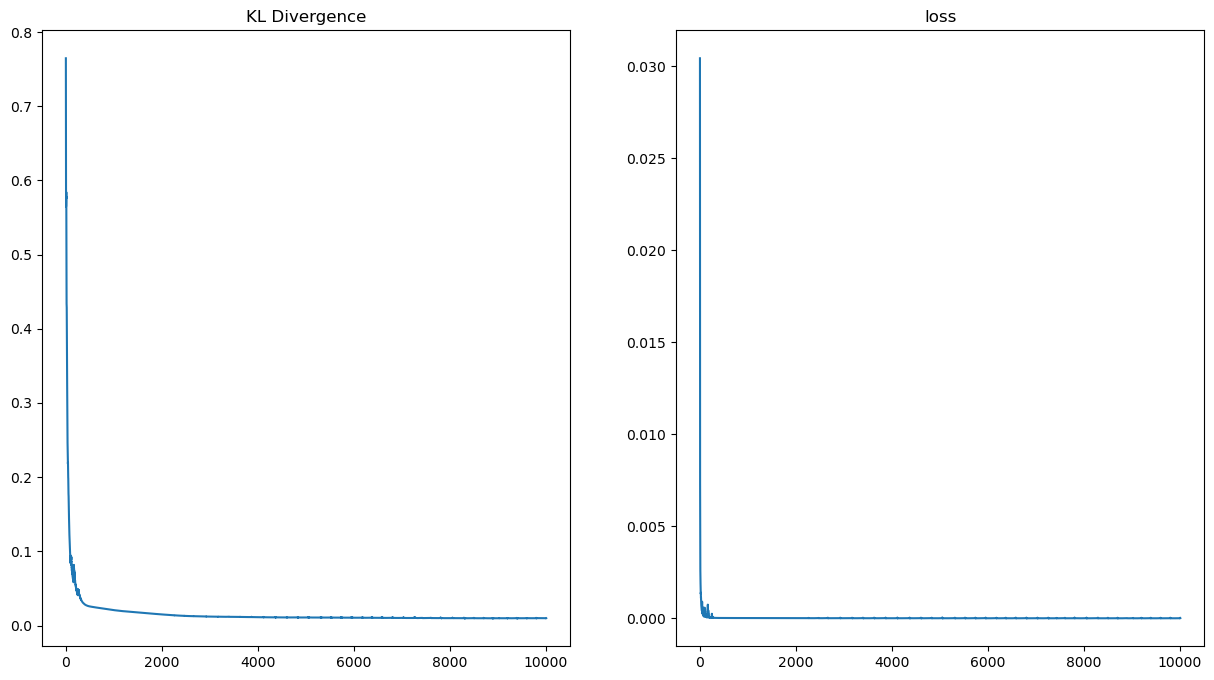

In [6]:
fig, axs = plt.subplots(1,2,figsize=(15,8))
axs[0].plot(divs)
axs[0].title.set_text('KL Divergence')

axs[1].plot(history)
axs[1].title.set_text('loss')

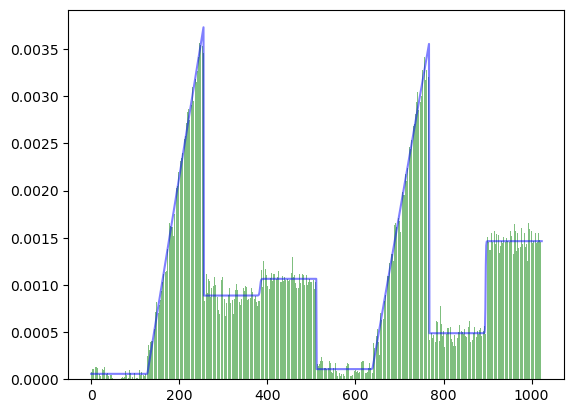

In [8]:
optimal_params = parameters[np.argmin(divs)]
qcbm_probs = circuit(optimal_params)
x_full = jnp.arange(0,2**n_qubits,dtype=jnp.float64)
plt.bar(x_full,qcbm_probs,color='green',alpha=0.5,label='obtained_distribution')
plt.plot(x_full,target_distribution,color='blue',alpha=0.5,label='target_distribution')

In [9]:
print(f"The minimum KL divergence obtained : {np.min(divs)}")

The minimum KL divergence obtained : 0.009779442101716995
